In [1]:
import datetime
import pandas as pd
from xgboost import XGBRegressor
import hopsworks
import json
from functions import utils
import os

In [2]:
from dotenv import load_dotenv
load_dotenv()
HOPSWORKS_API_KEY = os.getenv("HOPSWORKS_API_KEY")
os.environ["HOPSWORKS_API_KEY"] = HOPSWORKS_API_KEY

In [3]:
today = datetime.datetime.now() - datetime.timedelta(0)
tomorrow = today + datetime.timedelta(days = 1)
yesterday = today - datetime.timedelta(days = 1)
today

datetime.datetime(2025, 1, 31, 18, 29, 16, 814116)

In [4]:
project = hopsworks.login()
fs = project.get_feature_store() 

2025-01-31 18:29:16,878 INFO: Initializing external client


2025-01-31 18:29:16,882 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-01-31 18:29:18,430 INFO: Python Engine initialized.



Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1207494


In [5]:
CITY = "dublin"
STATION = "HEUSTON BRIDGE (NORTH)"

STATION = STATION.replace(" ", "_")

In [6]:
feature_view = fs.get_feature_view(
    name='bike_weather_fw',
    version=1,
)

In [7]:
mr = project.get_model_registry()

retrieved_model = mr.get_model(
    name="bike_availability_xgboost_model",
    version=1,
)

# Download the saved model artifacts to a local directory
saved_model_dir = retrieved_model.download()

In [8]:
retrieved_xgboost_model = XGBRegressor()

retrieved_xgboost_model.load_model(saved_model_dir + "/model.json")

# Displaying the retrieved XGBoost regressor model
# retrieved_xgboost_model

In [9]:
weather_fg = fs.get_feature_group(
    name='weather_data',
    version=1,
)

batch_data = weather_fg.filter(weather_fg.datetime >= today).read()
batch_data["month"] = batch_data["datetime"].dt.month
batch_data["weekday"] = batch_data["datetime"].dt.weekday  # 0=Monday, 6=Sunday
batch_data["hour"] = batch_data["datetime"].dt.hour
batch_data

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.02s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour
0,2025-01-31 23:00:00+00:00,2.05,-1.152123,0.0,0.0,8.350138,32065.236328,0.400000,dublin,1,4,23
1,2025-01-31 20:00:00+00:00,2.05,-0.790819,0.0,0.0,6.379216,32065.236328,0.400000,dublin,1,4,20
2,2025-01-31 21:00:00+00:00,1.80,-1.134183,0.0,0.0,6.569383,32065.236328,0.400000,dublin,1,4,21
3,2025-01-31 22:00:00+00:00,1.80,-1.250338,0.0,0.0,7.200000,32065.236328,0.400000,dublin,1,4,22
4,2025-02-01 02:00:00+00:00,2.45,-0.832028,0.0,0.0,9.000000,32284.416016,0.000000,dublin,2,5,2
...,...,...,...,...,...,...,...,...,...,...,...,...
215,2025-02-07 02:00:00+00:00,3.75,0.225555,0.0,0.0,9.693296,33655.035156,0.000000,dublin,2,4,2
216,2025-02-07 05:00:00+00:00,3.85,0.018793,0.0,0.0,12.475961,33655.035156,0.000000,dublin,2,4,5
217,2025-02-09 06:00:00+00:00,4.90,-0.746644,0.3,0.0,27.748037,34126.535156,5.699998,dublin,2,6,6
218,2025-02-08 14:00:00+00:00,7.55,3.588160,1.6,0.0,21.575987,33890.167969,30.800003,dublin,2,5,14


## Creating predictions

In [10]:
batch_data['predicted_bikes_available'] = retrieved_xgboost_model.predict(
    batch_data[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']]
)
batch_data['predicted_bikes_available'] = batch_data['predicted_bikes_available'].apply(lambda x: round(x))

batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available
0,2025-01-31 23:00:00+00:00,2.05,-1.152123,0.0,0.0,8.350138,32065.236328,0.400000,dublin,1,4,23,34
1,2025-01-31 20:00:00+00:00,2.05,-0.790819,0.0,0.0,6.379216,32065.236328,0.400000,dublin,1,4,20,34
2,2025-01-31 21:00:00+00:00,1.80,-1.134183,0.0,0.0,6.569383,32065.236328,0.400000,dublin,1,4,21,33
3,2025-01-31 22:00:00+00:00,1.80,-1.250338,0.0,0.0,7.200000,32065.236328,0.400000,dublin,1,4,22,33
4,2025-02-01 02:00:00+00:00,2.45,-0.832028,0.0,0.0,9.000000,32284.416016,0.000000,dublin,2,5,2,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...
215,2025-02-07 02:00:00+00:00,3.75,0.225555,0.0,0.0,9.693296,33655.035156,0.000000,dublin,2,4,2,42
216,2025-02-07 05:00:00+00:00,3.85,0.018793,0.0,0.0,12.475961,33655.035156,0.000000,dublin,2,4,5,43
217,2025-02-09 06:00:00+00:00,4.90,-0.746644,0.3,0.0,27.748037,34126.535156,5.699998,dublin,2,6,6,29
218,2025-02-08 14:00:00+00:00,7.55,3.588160,1.6,0.0,21.575987,33890.167969,30.800003,dublin,2,5,14,28


In [11]:
# Fill in the number of hours before the time on which you made the forecast (base_datetime)
batch_data = batch_data.sort_values(by=['datetime'])
batch_data['hours_before_forecast_time'] = range(1, len(batch_data) + 1)
batch_data

,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
1,2025-01-31 20:00:00+00:00,2.05,-0.790819,0.0,0.0,6.379216,32065.236328,0.400000,dublin,1,4,20,34,1
2,2025-01-31 21:00:00+00:00,1.80,-1.134183,0.0,0.0,6.569383,32065.236328,0.400000,dublin,1,4,21,33,2
3,2025-01-31 22:00:00+00:00,1.80,-1.250338,0.0,0.0,7.200000,32065.236328,0.400000,dublin,1,4,22,33,3
0,2025-01-31 23:00:00+00:00,2.05,-1.152123,0.0,0.0,8.350138,32065.236328,0.400000,dublin,1,4,23,34,4
9,2025-02-01 00:00:00+00:00,2.30,-1.018463,0.0,0.0,9.255571,32284.416016,0.000000,dublin,2,5,0,33,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2025-02-09 19:00:00+00:00,5.20,0.061158,0.1,0.0,23.806318,34126.535156,5.699998,dublin,2,6,19,30,216
206,2025-02-09 20:00:00+00:00,5.20,-0.020061,0.1,0.0,24.363251,34126.535156,5.699998,dublin,2,6,20,31,217
181,2025-02-09 21:00:00+00:00,5.20,-0.084013,0.1,0.0,24.590923,34126.535156,5.699998,dublin,2,6,21,30,218
207,2025-02-09 22:00:00+00:00,5.15,-0.177298,0.1,0.0,24.826952,34126.535156,5.699998,dublin,2,6,22,30,219


## Create forecast graph

2025-01-31 18:29:27,353 WARNING: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.



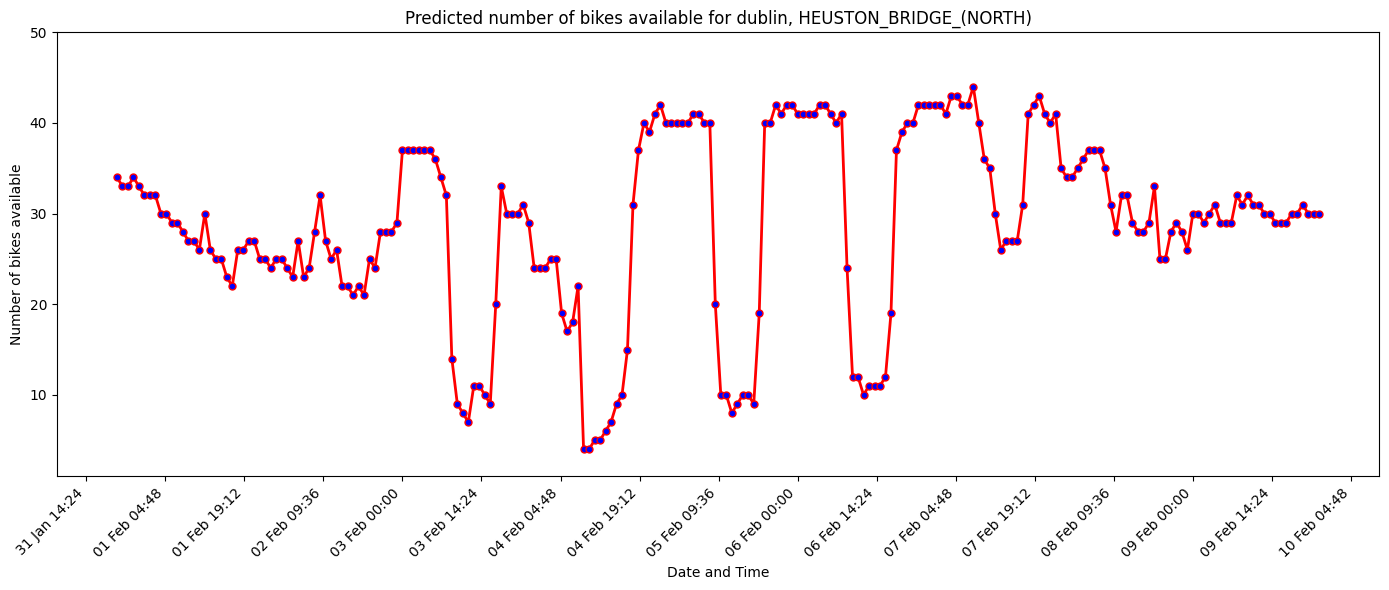

In [12]:
file_path = "docs/bike_availability_forecast.png"
plt = utils.plot_bike_availability_forecast(CITY, STATION, batch_data, file_path)
plt.show()

In [13]:
# Get or create feature group
monitor_fg = fs.get_or_create_feature_group(
    name='bike_availability_predictions',
    description='Bike availability prediction monitoring for ' + STATION.replace("_", " "),
    version=1,
    primary_key=["datetime", "city"],
    event_time="datetime"
)

In [14]:
monitor_fg.insert(batch_data, write_options={"wait_for_job": True})

Uploading Dataframe: 0.00% |                                     | Rows 0/220 | Elapsed Time: 00:00 | Remaining Time: ?

Uploading Dataframe: 91.36% |███████████████████████████▍  | Rows 201/220 | Elapsed Time: 00:01 | Remaining Time: 00:00

Uploading Dataframe: 100.00% |█████████████████████████████| Rows 220/220 | Elapsed Time: 00:01 | Remaining Time: 00:00

Launching job: bike_availability_predictions_1_offline_fg_materialization


Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai:443/p/1207494/jobs/named/bike_availability_predictions_1_offline_fg_materialization/executions


2025-01-31 18:29:48,322 INFO: Waiting for execution to finish. Current state: SUBMITTED. Final status: UNDEFINED


2025-01-31 18:29:51,522 INFO: Waiting for execution to finish. Current state: RUNNING. Final status: UNDEFINED


2025-01-31 18:32:09,281 INFO: Waiting for execution to finish. Current state: AGGREGATING_LOGS. Final status: SUCCEEDED


2025-01-31 18:32:09,443 INFO: Waiting for log aggregation to finish.


2025-01-31 18:32:31,626 INFO: Execution finished successfully.


(Job('bike_availability_predictions_1_offline_fg_materialization', 'SPARK'),
 None)

In [15]:
# We will create a hindcast chart for only the forecasts made 1 day beforehand
monitoring_df = monitor_fg.filter(monitor_fg.hours_before_forecast_time <= 24).read()
monitoring_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.17s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city,month,weekday,hour,predicted_bikes_available,hours_before_forecast_time
0,2025-01-24 03:00:00+00:00,11.30,5.056276,1.9,0.0,41.104683,30634.960938,7.5,dublin,1,4,3,41,18
1,2025-01-23 01:00:00+00:00,4.65,1.574594,0.0,0.0,11.019764,30442.521484,2.9,dublin,1,3,1,39,15
2,2025-01-25 05:00:00+00:00,1.30,-4.210609,0.0,0.0,20.326454,30829.769531,2.1,dublin,1,5,5,41,19
3,2025-01-27 04:00:00+00:00,5.60,1.149379,0.1,0.0,17.418196,31225.949219,8.4,dublin,1,0,4,30,16
4,2025-01-24 10:00:00+00:00,5.55,-3.144419,0.0,0.0,45.814861,30634.960938,6.0,dublin,1,4,10,34,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,2025-02-01 02:00:00+00:00,2.45,-0.832028,0.0,0.0,9.000000,32284.416016,0.0,dublin,2,5,2,32,7
229,2025-02-01 06:00:00+00:00,4.40,0.781394,0.0,0.0,13.217443,32284.416016,0.0,dublin,2,5,6,29,11
230,2025-02-01 10:00:00+00:00,7.10,3.703910,0.0,0.0,14.578888,32284.416016,0.0,dublin,2,5,10,27,15
231,2025-02-01 01:00:00+00:00,2.40,-0.915362,0.0,0.0,9.346143,32284.416016,0.0,dublin,2,5,1,32,6


In [16]:
bike_fg = fs.get_feature_group(
    name='bike_data',
    version=1,
)
bike_df = bike_fg.read()

bike_df

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.40s) 


,datetime,station,num_bikes_available
0,2024-09-23 10:00:00+00:00,HEUSTON_BRIDGE_(NORTH),2.0
1,2023-10-07 13:00:00+00:00,HEUSTON_BRIDGE_(NORTH),29.0
2,2023-11-27 07:00:00+00:00,HEUSTON_BRIDGE_(NORTH),34.0
3,2024-01-22 22:00:00+00:00,HEUSTON_BRIDGE_(NORTH),35.0
4,2023-10-16 02:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
...,...,...,...
9809,2025-01-29 01:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9810,2025-01-30 04:00:00+00:00,HEUSTON_BRIDGE_(NORTH),40.0
9811,2025-01-29 17:00:00+00:00,HEUSTON_BRIDGE_(NORTH),9.0
9812,2025-01-28 11:00:00+00:00,HEUSTON_BRIDGE_(NORTH),9.0


In [17]:
weather_fg.read()

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (0.86s) 


,datetime,temperature_2m,apparent_temperature,rain,snowfall,wind_speed_10m,daylight_duration,rain_sum,city
0,2024-11-17 07:00:00+00:00,6.6395,3.542508,0.0,0.0,13.091829,30647.093750,2.600000,dublin
1,2024-07-26 02:00:00+00:00,12.0395,9.959105,0.0,0.0,15.349684,57427.019531,0.900000,dublin
2,2024-08-02 09:00:00+00:00,18.9895,18.108223,0.0,0.0,19.469975,56053.718750,2.500000,dublin
3,2024-03-28 18:00:00+00:00,8.1395,6.004910,0.1,0.0,4.334974,46005.636719,1.300000,dublin
4,2024-01-09 08:00:00+00:00,3.7895,-1.855704,0.0,0.0,21.602999,28177.490234,0.000000,dublin
...,...,...,...,...,...,...,...,...,...
12931,2025-02-07 02:00:00+00:00,3.7500,0.225555,0.0,0.0,9.693296,33655.035156,0.000000,dublin
12932,2025-02-07 05:00:00+00:00,3.8500,0.018793,0.0,0.0,12.475961,33655.035156,0.000000,dublin
12933,2025-02-09 06:00:00+00:00,4.9000,-0.746644,0.3,0.0,27.748037,34126.535156,5.699998,dublin
12934,2025-02-08 14:00:00+00:00,7.5500,3.588160,1.6,0.0,21.575987,33890.167969,30.800003,dublin


In [18]:
def backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, model):
    features_df = weather_fg.read()

    features_df["month"] = features_df["datetime"].dt.month
    features_df["weekday"] = features_df["datetime"].dt.weekday  # 0=Monday, 6=Sunday
    features_df["hour"] = features_df["datetime"].dt.hour

    features_df = pd.merge(features_df, bike_df[['datetime','num_bikes_available']], on="datetime")
    features_df = features_df.sort_values(by=['datetime'], ascending=True)
    features_df = features_df.tail(10*24)
    
    features_df['predicted_bikes_available'] = model.predict(features_df[['temperature_2m', 'apparent_temperature', 'rain', 'snowfall', 'wind_speed_10m', 'daylight_duration', 'rain_sum', 'month', 'weekday', 'hour']])
    features_df['predicted_bikes_available'] = features_df['predicted_bikes_available'].apply(lambda x: round(x))

    features_df['hours_before_forecast_time'] = range(1, len(features_df) + 1)
    hindcast_df = features_df
    features_df = features_df.drop('num_bikes_available', axis=1)
    monitor_fg.insert(features_df, write_options={"wait_for_job": True})
    return hindcast_df

In [19]:
outcome_df = bike_df[['datetime', 'num_bikes_available']]
preds_df =  monitoring_df[['datetime', 'predicted_bikes_available']]

hindcast_df = pd.merge(preds_df, outcome_df, on="datetime")
hindcast_df = hindcast_df.sort_values(by=['datetime'])
print(len(hindcast_df))
hindcast_df

209


,datetime,predicted_bikes_available,num_bikes_available
208,2024-12-28 01:00:00+00:00,39,39.0
191,2024-12-28 02:00:00+00:00,40,39.0
201,2024-12-28 03:00:00+00:00,40,39.0
185,2024-12-28 04:00:00+00:00,39,39.0
193,2024-12-28 05:00:00+00:00,38,39.0
...,...,...,...
12,2025-01-29 04:00:00+00:00,39,40.0
154,2025-01-29 05:00:00+00:00,40,40.0
180,2025-01-29 06:00:00+00:00,40,40.0
91,2025-01-29 07:00:00+00:00,38,40.0


In [20]:
outcome_df = outcome_df.sort_values(by=['datetime'])
outcome_df

,datetime,num_bikes_available
5695,2023-08-07 02:00:00+00:00,10.0
2161,2023-08-07 03:00:00+00:00,10.0
3422,2023-08-07 04:00:00+00:00,10.0
8312,2023-08-07 05:00:00+00:00,10.0
2192,2023-08-07 06:00:00+00:00,10.0
...,...,...
9774,2025-01-30 20:00:00+00:00,40.0
9776,2025-01-30 21:00:00+00:00,40.0
9755,2025-01-30 22:00:00+00:00,38.0
9769,2025-01-30 23:00:00+00:00,37.0


In [21]:
preds_df = preds_df.sort_values(by=['datetime'])
preds_df

,datetime,predicted_bikes_available
208,2024-12-28 01:00:00+00:00,39
191,2024-12-28 02:00:00+00:00,40
201,2024-12-28 03:00:00+00:00,40
185,2024-12-28 04:00:00+00:00,39
193,2024-12-28 05:00:00+00:00,38
...,...,...
232,2025-02-01 15:00:00+00:00,25
216,2025-02-01 16:00:00+00:00,23
221,2025-02-01 17:00:00+00:00,22
223,2025-02-01 18:00:00+00:00,26


In [22]:

# If there are no outcomes for predictions yet, generate some predictions/outcomes from existing data
print("Hindcast length: ", len(hindcast_df))
if len(hindcast_df) == 0:
    hindcast_df = backfill_predictions_for_monitoring(weather_fg, bike_df, monitor_fg, retrieved_xgboost_model)
hindcast_df

Hindcast length:  209


,datetime,predicted_bikes_available,num_bikes_available
208,2024-12-28 01:00:00+00:00,39,39.0
191,2024-12-28 02:00:00+00:00,40,39.0
201,2024-12-28 03:00:00+00:00,40,39.0
185,2024-12-28 04:00:00+00:00,39,39.0
193,2024-12-28 05:00:00+00:00,38,39.0
...,...,...,...
12,2025-01-29 04:00:00+00:00,39,40.0
154,2025-01-29 05:00:00+00:00,40,40.0
180,2025-01-29 06:00:00+00:00,40,40.0
91,2025-01-29 07:00:00+00:00,38,40.0


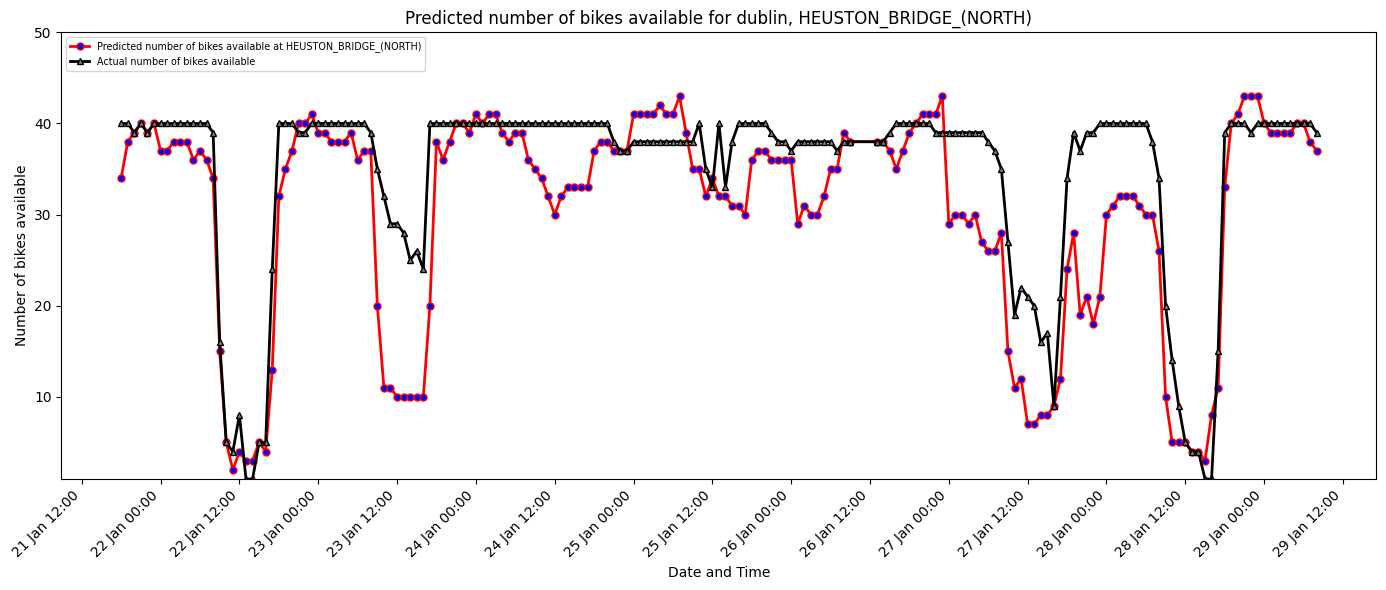

In [23]:
file_path = "docs/bike_availability_hindcast_10days.png"
import pytz

today = datetime.datetime.now(pytz.utc)
hindcast_df_10days = hindcast_df[hindcast_df['datetime'] >= today - datetime.timedelta(days=10)]

plt = utils.plot_bike_availability_forecast(CITY, STATION, hindcast_df_10days, file_path, hindcast=True)
plt.show()